# Exercise 7.2
Download the flows for at least two different US States from [this repository](https://github.com/GeoDS/COVID19USFlows), create and plot a FlowDataFrame. Then:
* split the FlowDataFrame into a training set and a test set;
* train the Gravity and Radiation models on the training set
* test the models' goodness on the test set (qualitative and quantitative evaluation). Use population as location relevance.
* Compare the two models with appropriate plots and/or tables.
* Repeat using the number of Education facilities in each location instead of the popultion (i.e., total count of POIs and buildings related to all education facilities, e.g., school, college, kindergarten, etc.).
* Submit a well-commented notebook.

*Warning: I had to leave just a snapshot of the maps in order to reduce the size of the notebook (well over 100mb with all the maps, 6mb with just pictures)*

### Install the Libraries

In [1]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi
!pip install overpass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 4.9 MB/s 
     |███████████████

## Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

#utilities
import urllib.request
import requests
import random
import math
import os
import codecs #bc some files have some strange encodings

#scikitmobility library
import skmob
from skmob.utils.plot import plot_gdf

#in case I want to plot a heatmap
import folium
from folium.plugins import HeatMap

#importing shapely geometries
from shapely.geometry import *

#models used
from skmob.models.gravity import Gravity
from skmob.models.radiation import Radiation

#metrics to evaluate the models
from skmob.measures.evaluation import r_squared, mse
from skmob.measures.evaluation import spearman_correlation, pearson_correlation
from skmob.measures.evaluation import common_part_of_commuters, common_part_of_commuters_distance

#OSM API wrapper (to download the education facilities' locations)
import overpass

#to remove the 
import warnings
warnings.filterwarnings("ignore")

## Download Function

In [3]:
#to quickly download files and get their name (I used the last part after the slash as name)
def download_file(url):
    file_name = url[url.rfind('/')+1:]
    urllib.request.urlretrieve(url, file_name)
    return file_name

## Downloading Files From Repo

In [4]:
download_file("https://raw.githubusercontent.com/GeoDS/COVID19USFlows/master/codes/download_daily_data.py")

'download_daily_data.py'

Running the repo utility to download U.S. mobility data since 2020

In [5]:
saving_in = 'daily_flows'
type_of_data = 'county2county'
!python download_daily_data.py --start_year 2020 --start_month 1 --start_day 1 --output_folder daily_flows --county

## Downloading US Shapes

### States' Shapes

Getting the json of the us states

In [6]:
geojson_shapes = download_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json")
geojson_shapes

'gz_2010_us_040_00_500k.json'

In [7]:
us_states_gpd = gpd.read_file(geojson_shapes)
us_states_gpd.head()

GEO_ID STATE           NAME LSAD  CENSUSAREA  \
0  0400000US23    23          Maine        30842.923   
1  0400000US25    25  Massachusetts         7800.058   
2  0400000US26    26       Michigan        56538.901   
3  0400000US30    30        Montana       145545.801   
4  0400000US32    32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...  
2  MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...  
3  POLYGON ((-104.05770 44.99743, -104.25015 44.9...  
4  POLYGON ((-114.05060 37.00040, -114.04999 36.9...

### Making a Dictionary { Name_State : Geometry } and { Name_State : State_Code }

In [8]:
us_states_geodict = dict()
us_states_iddict = dict()

for n, row in us_states_gpd.iterrows():
    us_states_geodict[row.NAME] = row.geometry
    us_states_iddict[row.NAME] = row.STATE

In [ ]:
#plotting the collection of the two geometries
collection = GeometryCollection((us_states_geodict['Washington'], us_states_geodict['Nevada']))
collection

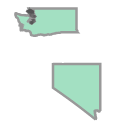

In [10]:
#creating a geopandas dataframe of the two state
washington_state = gpd.GeoDataFrame(geometry=[us_states_geodict['Washington']], crs = 'EPSG:4326')
nevada_state = gpd.GeoDataFrame(geometry=[us_states_geodict['Nevada']], crs = 'EPSG:4326')
#to filter in one line with the spatial join (to avoid scanning twice):
collection_states = gpd.GeoDataFrame(geometry=[collection], crs = 'EPSG:4326')

### Counties' Shapes (the tessellation)

In [11]:
#downloading the file of the counties from the same website
counties = download_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_500k.json")

In [12]:
#creating a gpd from the file of the counties
with codecs.open(counties, 'r', encoding='utf-8', errors='ignore') as f:
    counties_gpd = gpd.read_file(f)

In [13]:
counties_gpd.head()

GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029   Cleburne  County     560.100   
1  0500000US01031    01    031     Coffee  County     678.972   
2  0500000US01037    01    037      Coosa  County     650.926   
3  0500000US01039    01    039  Covington  County    1030.456   
4  0500000US01041    01    041   Crenshaw  County     608.840   

                                            geometry  
0  POLYGON ((-85.38872 33.91304, -85.38089 33.873...  
1  POLYGON ((-86.03044 31.61894, -86.00409 31.619...  
2  POLYGON ((-86.00928 33.10164, -86.00917 33.090...  
3  POLYGON ((-86.34851 30.99434, -86.35023 30.994...  
4  POLYGON ((-86.14699 31.68045, -86.14711 31.663...

In [14]:
#getting a state code to name of state dictionary
reverse_code_name_states = {ccode: name for name, ccode in us_states_iddict.items()}

In [15]:
#grouping counties by country and listing the geo id inside, then creating a dictionary to call everything by the state code
country_counties_grouped = dict(counties_gpd.groupby('STATE').apply(lambda x: list(x.GEO_ID)))

I want to use the name of the state to have the list of the counties (and not just the state code)

In [16]:
country_counties_grouped['11']

['0500000US11001']

In [17]:
reverse_code_name_states['11']

'District of Columbia'

In [18]:
#I loop across the dictionary to get the corresponding name as a key to the counties
zipped_ccg = country_counties_grouped.items()

country_counties_dict = dict()

for country_code, counties in zipped_ccg:
    country_name = reverse_code_name_states[country_code]
    country_counties_dict[country_name] = counties

In [19]:
country_counties_dict['District of Columbia']

['0500000US11001']

## Downloading US population by County

In [20]:
#I download with pandas some data about U.S. population
population_df = pd.read_csv('https://odn.data.socrata.com/api/views/tx2x-uhib/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*')

In [21]:
population_df['type'].unique()

array(['nation', 'region', 'division', 'state', 'county', 'place',
       'zip_code', 'msa'], dtype=object)

In [22]:
population_df.head()

id           name    type  year  population  \
0  0100000US  United States  nation  2013   311536594   
1  0100000US  United States  nation  2012   309138711   
2  0100000US  United States  nation  2011   306603772   
3  0100000US  United States  nation  2010   303965272   
4  0100000US  United States  nation  2009   301461533   

   population_percent_change  
0                      0.776  
1                      0.827  
2                      0.868  
3                      0.831  
4                      0.000

In [23]:
#I group by id
pop_iter = population_df.groupby('id').apply(lambda x: (x.id, x.year, x.population))

### Making a Dictionary { Tile : Population }

In [24]:
#getting only the population data at the latest available date
population_dict = dict()

for id, year, pop in pop_iter:
    max_val = np.argmax(year) #max available date index (each id, year, pop is a list)
    population_dict[id.values[max_val]] = pop.values[max_val]

In [25]:
list(population_dict.items())[:6]

[('0100000US', 311536594),
 ('0200000US1', 55564549),
 ('0200000US2', 67148157),
 ('0200000US3', 116015264),
 ('0200000US4', 72808624),
 ('0300000US1', 14513709)]

In [26]:
#mapping the population from the corresponding geo id
counties_gpd['POPULATION'] = list(map(lambda x: population_dict[x], counties_gpd.GEO_ID))

In [27]:
counties_gpd.head()

GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029   Cleburne  County     560.100   
1  0500000US01031    01    031     Coffee  County     678.972   
2  0500000US01037    01    037      Coosa  County     650.926   
3  0500000US01039    01    039  Covington  County    1030.456   
4  0500000US01041    01    041   Crenshaw  County     608.840   

                                            geometry  POPULATION  
0  POLYGON ((-85.38872 33.91304, -85.38089 33.873...       14945  
1  POLYGON ((-86.03044 31.61894, -86.00409 31.619...       50468  
2  POLYGON ((-86.00928 33.10164, -86.00917 33.090...       11198  
3  POLYGON ((-86.34851 30.99434, -86.35023 30.994...       37847  
4  POLYGON ((-86.14699 31.68045, -86.14711 31.663...       13955

## Plotting the Tessellation

In [ ]:
plot_gdf(counties_gpd, zoom = 4)

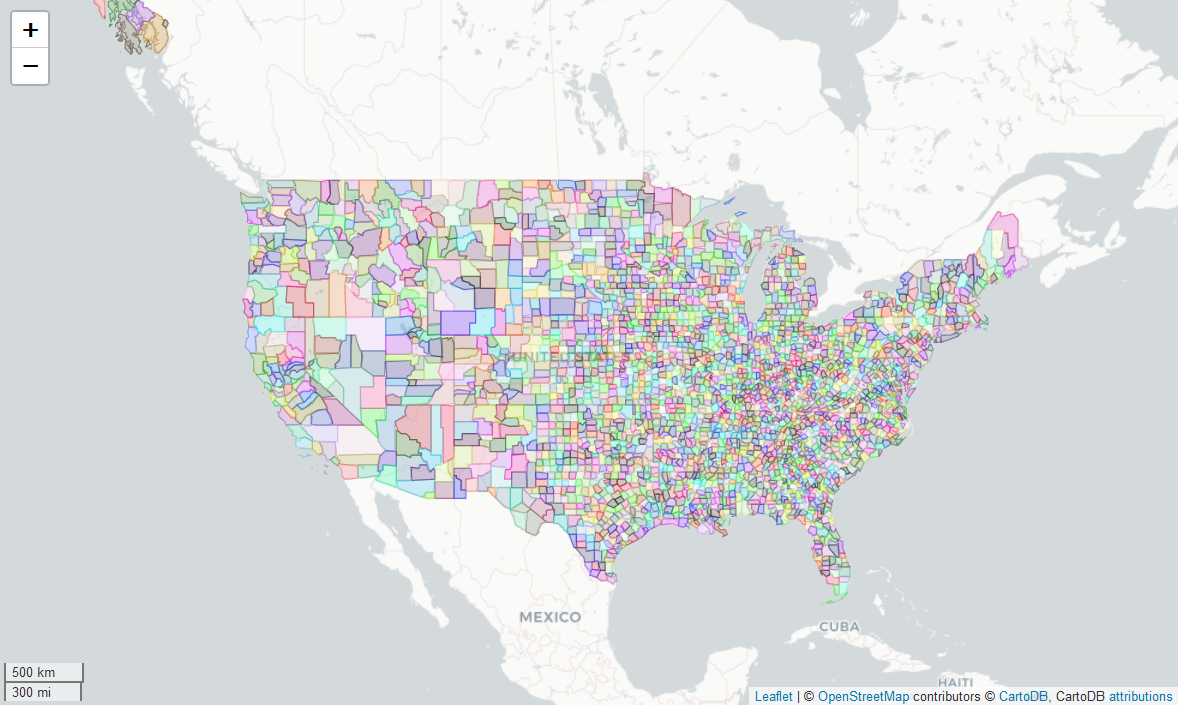

### Plotting the two States I will focus on

Cannot perform a spatial join as the geometries of the state do not match perfectly with those of the counties, thus I decided to use the STATE

In [ ]:
#getting the counties of the two states by using the state code to filter the counties
washington_statecode = us_states_iddict['Washington']
nevada_statecode = us_states_iddict['Nevada']

washington_tess = counties_gpd[counties_gpd.STATE == washington_statecode]
nevada_tess = counties_gpd[counties_gpd.STATE == nevada_statecode]

#plotting both
plot_gdf(counties_gpd.loc[list(washington_tess.index) + list(nevada_tess.index)], zoom = 5)

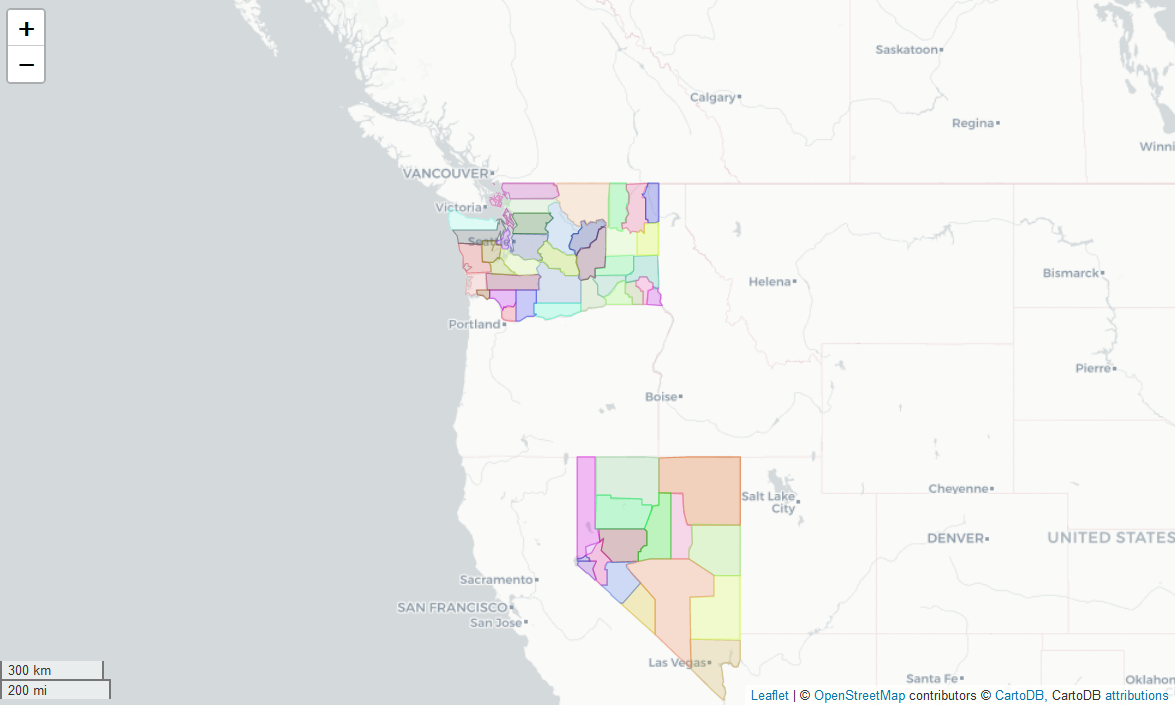

## Preprocess the Dataset

In [30]:
#geth the path and file downloaded in a previous cell
path = f'{saving_in}/{type_of_data}'
csv_name = os.listdir(path)[0]
csv_name

'daily_county2county_2020_01_01.csv'

In [31]:
#loading the data
df = pd.read_csv(f"{path}/{csv_name}")
df.head()

geoid_o  geoid_d      lng_o      lat_o      lng_d      lat_d        date  \
0     1001     1001 -86.642757  32.534921 -86.642757  32.534921  2020-01-01   
1     1001     1003 -86.642757  32.534921 -87.749845  30.660974  2020-01-01   
2     1001     1005 -86.642757  32.534921 -85.393197  31.869603  2020-01-01   
3     1001     1007 -86.642757  32.534921 -87.126439  32.998644  2020-01-01   
4     1001     1009 -86.642757  32.534921 -86.567371  33.980867  2020-01-01   

   visitor_flows  pop_flows  
0           7327    73321.0  
1             35      350.0  
2              1       10.0  
3             10      100.0  
4              1       10.0

### Getting the Geometries

In [32]:
#just extracting the geometries of origin and destination of the flows
origin_geometry = gpd.points_from_xy(df.lng_o, df.lat_o)
destination_geometry = gpd.points_from_xy(df.lng_d, df.lat_d)

### Creating GeoDataFrames
I made them to make a Spatial Join to focus only on intrastate movements

In [33]:
#creating two gpd df for origin and destination
gpd_origin = gpd.GeoDataFrame(df[['geoid_o']], 
                              geometry=origin_geometry, 
                              crs = 'EPSG:4326').drop_duplicates().reset_index(drop=True).rename(columns={'geoid_o':'geoid'})

gpd_destination = gpd.GeoDataFrame(df[['geoid_d']], 
                                   geometry=destination_geometry, 
                                   crs = 'EPSG:4326').drop_duplicates().reset_index(drop=True).rename(columns={'geoid_d':'geoid'})

In [34]:
#getting a single dataframe and filtering duplicate tiles
concat_od = pd.concat((gpd_origin, gpd_destination)).drop_duplicates().reset_index(drop=True)

### Building the FlowDataFrame

I used the nearest join to get the points in the sea included (e.g. some points beyond the coast in florida)

In [35]:
#spatial join between the dataset tiles and the geometries with the real state shapes
#I did it to connect geoid and GEO_ID from the two sets
county_tiles = gpd.sjoin_nearest(concat_od, counties_gpd).drop('index_right', axis=1).drop_duplicates().reset_index(drop=True)
len(county_tiles)

3219

In [36]:
county_tiles.head()

geoid                    geometry          GEO_ID STATE COUNTY     NAME  \
0   1001  POINT (-86.64276 32.53492)  0500000US01001    01    001  Autauga   
1   1003  POINT (-87.74984 30.66097)  0500000US01003    01    003  Baldwin   
2   1007  POINT (-87.12644 32.99864)  0500000US01007    01    007     Bibb   
3   1009  POINT (-86.56737 33.98087)  0500000US01009    01    009   Blount   
4   1011  POINT (-85.71570 32.10055)  0500000US01011    01    011  Bullock   

     LSAD  CENSUSAREA  POPULATION  
0  County     594.436       54907  
1  County    1589.784      187114  
2  County     622.582       22754  
3  County     644.776       57623  
4  County     622.805       10746

In [37]:
#creating a dictionary to map the geoid with the GEO_ID (the latter has the state shapes connected to it)
mapper_geoid = {geoid : new_geoid for geoid, new_geoid in zip(county_tiles.geoid, county_tiles.GEO_ID)}

In [38]:
#mapping the new features to consider (just adding them as extra cols to the df with the default names of skmob)
df['origin'] = list(map(lambda x: mapper_geoid[x], df.geoid_o))
df['destination'] = list(map(lambda x: mapper_geoid[x], df.geoid_d))
df['time'] = df.date
df['flow'] = df.visitor_flows #using this because it is the real recorded flow
df['weight'] = df.pop_flows #using this as a weight because it was inferred from the previous (intrisic weight (?))

In [39]:
tessellation = counties_gpd[['GEO_ID', 'POPULATION', 'geometry']]

In [40]:
flows = df[['origin', 'destination', 'time', 'flow', 'weight']]

In [41]:
#creating the whole U.S. flow dataframe
fdf = skmob.FlowDataFrame(flows, tile_id = 'GEO_ID', tessellation = tessellation)

### Filtering out movements in other countries
The following was done to visualize what I would cut later (outer flows towards other states and from outside towards counties of the states)

In [42]:
origin_train = gpd.sjoin(gpd.GeoDataFrame(geometry=origin_geometry), washington_tess)
destination_train = gpd.sjoin(gpd.GeoDataFrame(geometry=destination_geometry), washington_tess)

indexes_washington = list(set(list(origin_train.index)+list(destination_train.index)))

washington_fdf = fdf.loc[indexes_washington].reset_index(drop=True)

In [43]:
origin_test = gpd.sjoin(gpd.GeoDataFrame(geometry=origin_geometry), nevada_tess)
destination_test = gpd.sjoin(gpd.GeoDataFrame(geometry=destination_geometry), nevada_tess)

indexes_nevada = list(set(list(origin_test.index)+list(destination_test.index)))

nevada_fdf = fdf.loc[indexes_nevada].reset_index(drop=True)

In [44]:
len(fdf)

678432

In [45]:
len(washington_fdf)

14668

In [46]:
len(nevada_fdf)

6711

### EXTRA: Plotting flows to and from the 2 states

In [ ]:
tess_map = washington_fdf.plot_tessellation(zoom = 4)
washington_fdf.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

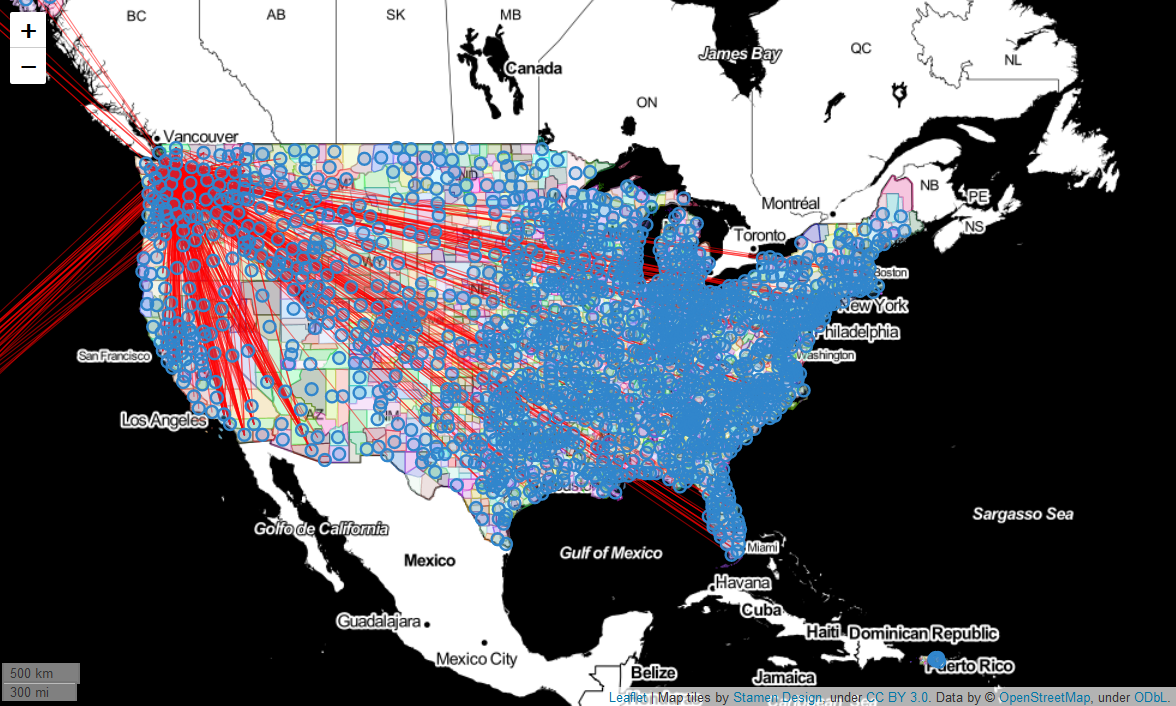

In [ ]:
tess_map = nevada_fdf.plot_tessellation(zoom = 4)
nevada_fdf.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

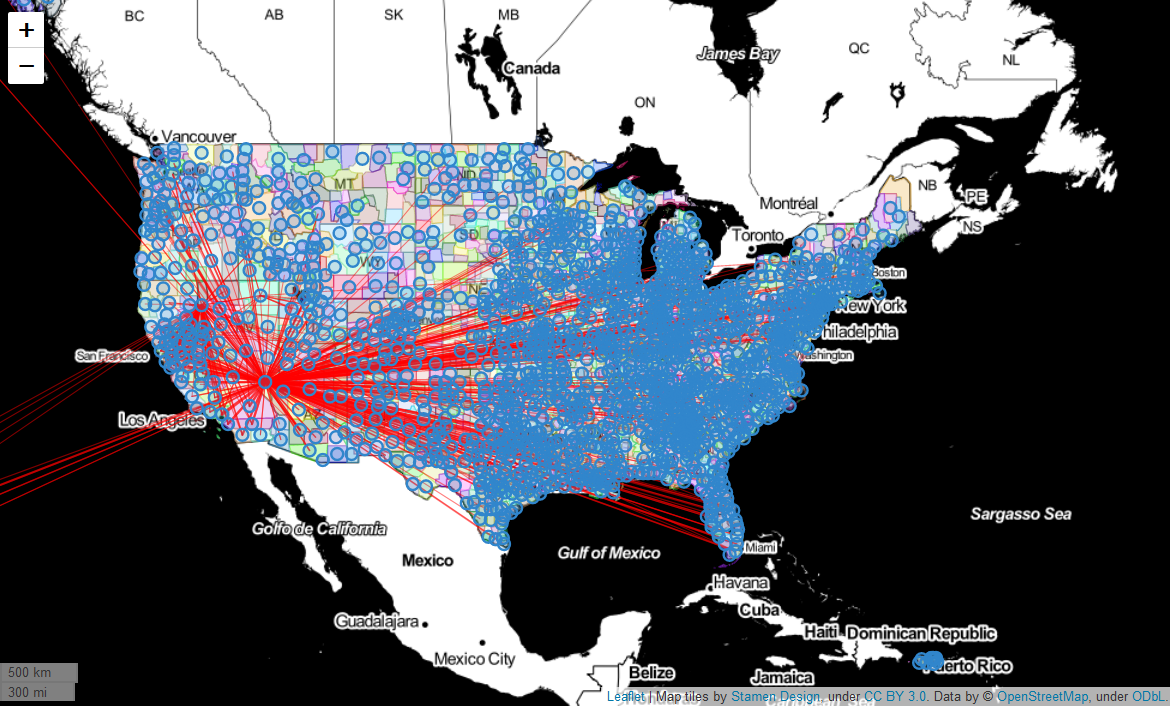

### Filtering out movements towards and from other states

In [49]:
#considering I already computed the indexes I just intersect them to exclude outer flows
indexes_to_train = list(set(origin_train.index).intersection(set(destination_train.index)))
indexes_to_test = list(set(origin_test.index).intersection(set(destination_test.index)))

#creating the flow dataframe of training and test set
train_fdf = skmob.FlowDataFrame(fdf.loc[indexes_to_train].reset_index(drop=True), 
                                tile_id = 'GEO_ID', tessellation = washington_tess)
test_fdf = skmob.FlowDataFrame(fdf.loc[indexes_to_test].reset_index(drop=True), 
                                tile_id = 'GEO_ID', tessellation = nevada_tess)

### TRAINING DATA VISUALIZATION

In [ ]:
tess_map = train_fdf.plot_tessellation(zoom = 6)
train_fdf.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

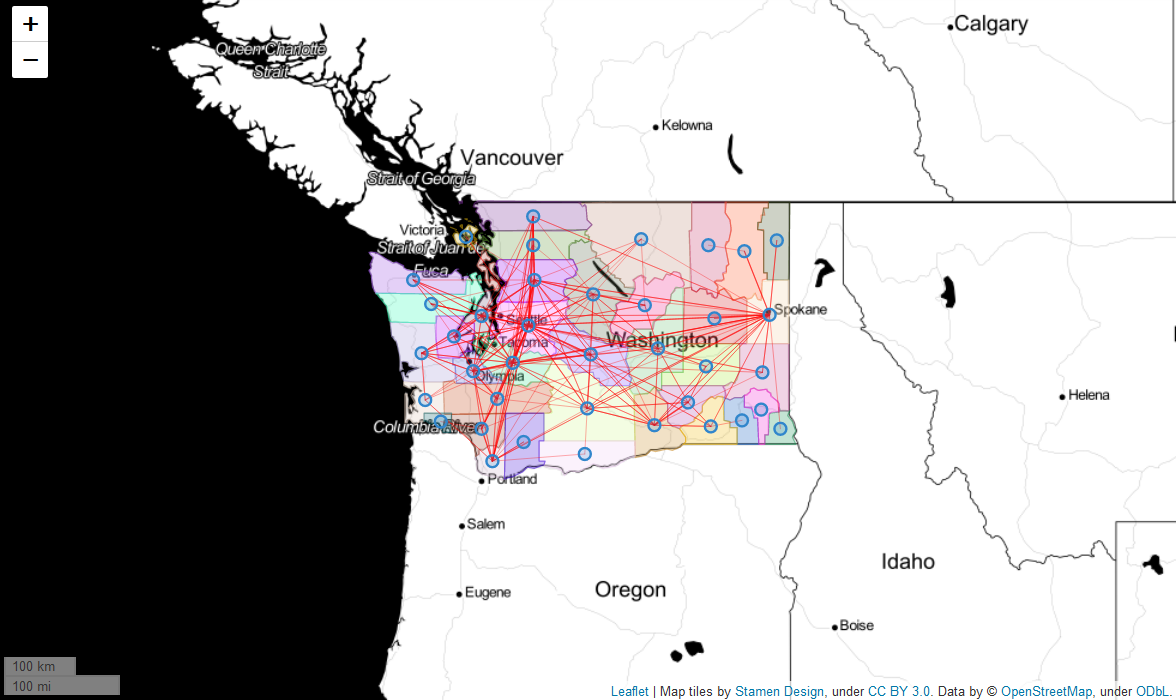

### TEST DATA VISUALIZATION

In [ ]:
tess_map = test_fdf.plot_tessellation(zoom = 6)
test_fdf.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

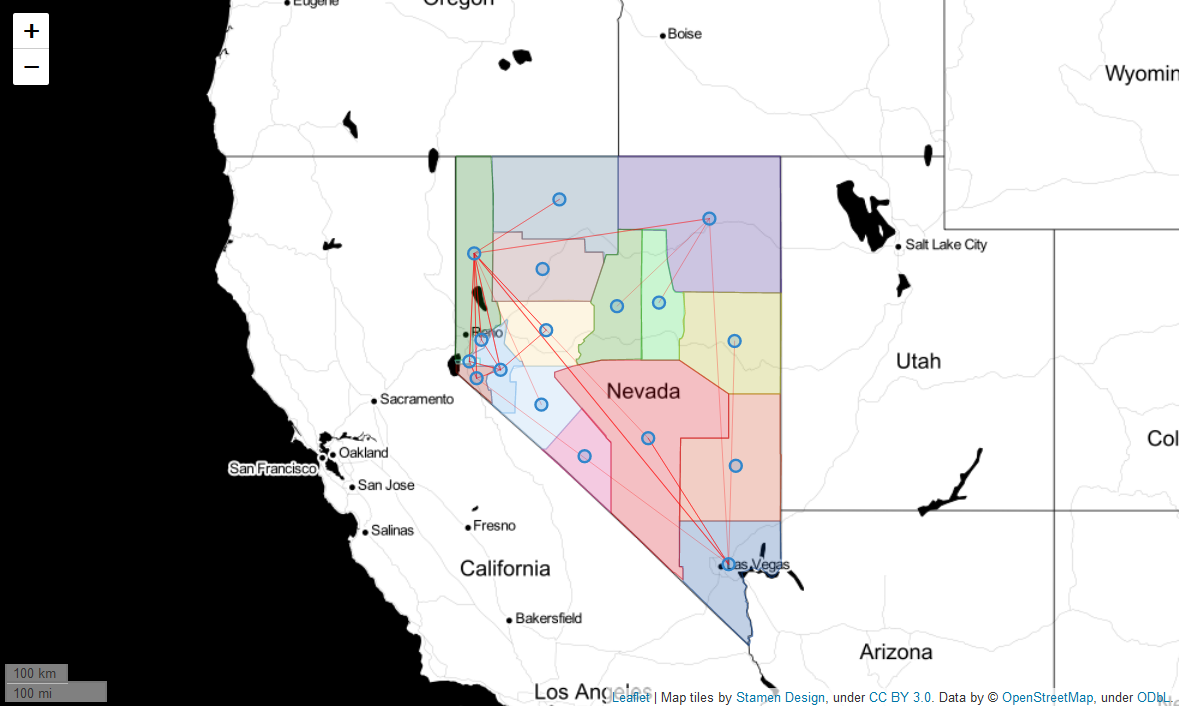

### Removing Inner Loops and Total Outflows

In [52]:
# Computing tot outflows removing movements to and from the same Tile
tot_outflows = train_fdf[train_fdf['origin'] != train_fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
# Adding the tot_outflow to the tessellation
train_fdf_tessellation = train_fdf.tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})

In [53]:
# Computing tot outflows removing movements to and from the same Tile
tot_outflows = test_fdf[test_fdf['origin'] != test_fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
# Adding the tot_outflow to the tessellation
test_fdf_tessellation = test_fdf.tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})

# Models with Population as Relevance

## Gravity Model

### Training a Singly Constrained Gravity Model

In [54]:
#instantiating the model and training it with Population as the tile relevance
gravity_singly = Gravity(gravity_type='singly constrained')
gravity_singly.fit(train_fdf, relevance_column = 'POPULATION')

### Generating flows in Nevada with the model trained on Washington's Flows

In [55]:
#generating the flows
grav_result = gravity_singly.generate(test_fdf_tessellation, tile_id_column='tile_ID', 
                                      tot_outflows_column='tot_outflow', relevance_column= 'POPULATION', out_format='flows')

100%|██████████| 17/17 [00:00<00:00, 1508.55it/s]


In [ ]:
#plotting the resulting flows of the gravity model
tess_map = grav_result.plot_tessellation(zoom = 6)
grav_result.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

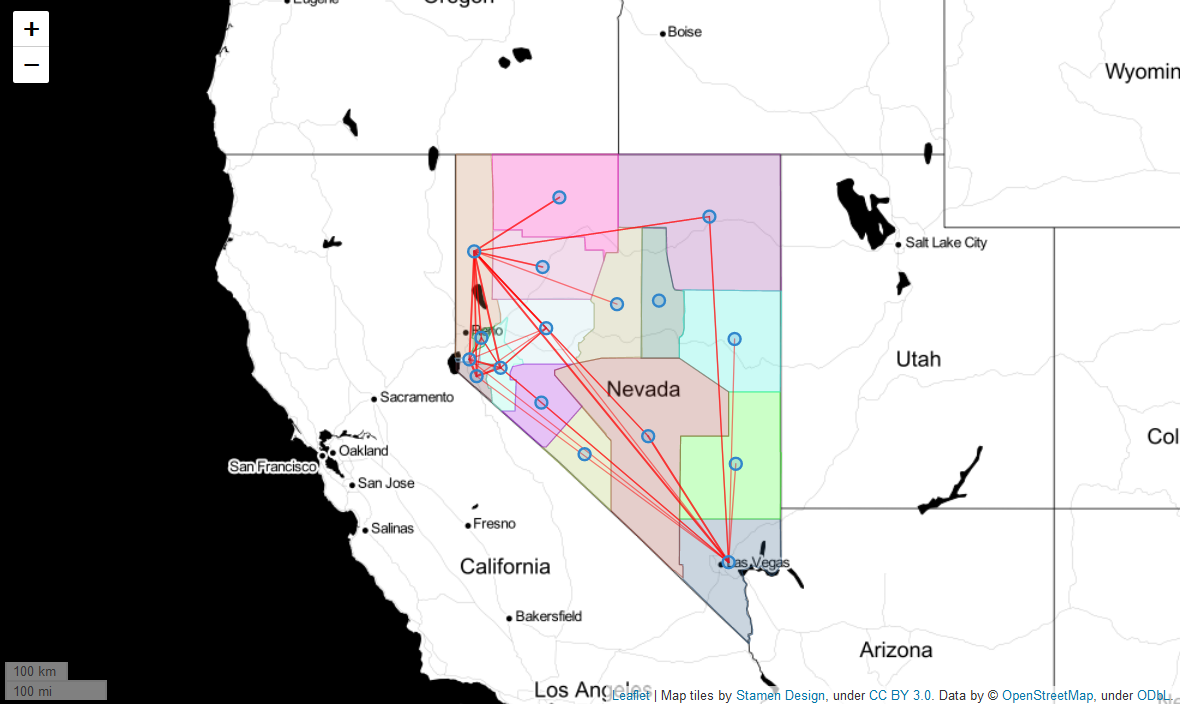

### Generating a Baseline to compare the model to

In [ ]:
#instantiating a baseline model without training
baseline = Gravity(gravity_type='singly constrained', 
                   deterrence_func_args=[0.], destination_exp=0.)

#generating the flows 
baseline_fdf = baseline.generate(test_fdf_tessellation, 
                                 tile_id_column='tile_ID', 
                                 tot_outflows_column='tot_outflow',
                                 relevance_column = 'POPULATION')

#plotting the tessellation
tess_map = grav_result.plot_tessellation(zoom = 6)

#plotting the baseline flows in blue
baseline_fdf.plot_flows(map_f = tess_map, flow_color='blue',
                        flow_weight = 1, flow_exp = 0.2, min_flow = 30)

#plotting the test flows in red
test_fdf.plot_flows(map_f=tess_map, flow_color='red', 
                    flow_weight = 1, flow_exp = 0.2, min_flow = 30)

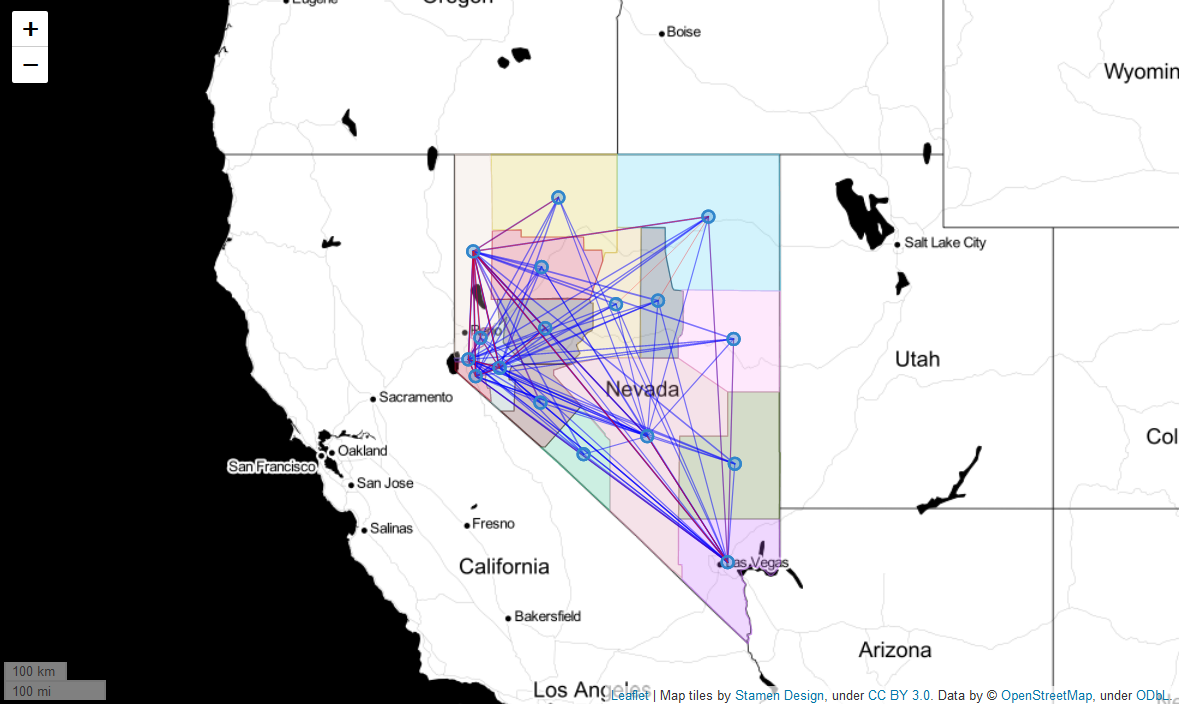

### Qualitative Evaluation

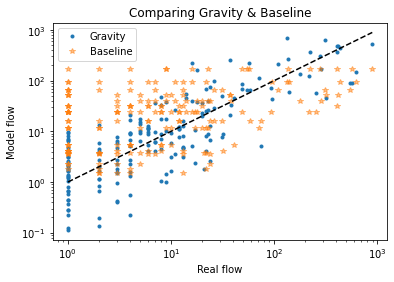

In [58]:
#comparing the test flows with those generated by the gravity model 
xy_grav = test_fdf.merge(grav_result, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
#comparing the test flows with those generated by the baseline model 
xy_baseline = test_fdf.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

#plotting them
plt.plot(xy_grav[:,0], xy_grav[:,1], '.', label='Gravity')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')

x = np.logspace(0, np.log10(np.max(xy_grav)))
plt.plot(x, x, '--k')

plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Gravity & Baseline')
plt.show()

### Quantitative Evaluation

In [59]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_grav = list()

for i, metric in enumerate(metrics):
    m = metric(xy_grav[:, 0], xy_grav[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    baseline_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_grav.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {baseline_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Gravity \t\t Baseline')
print('-'*int(1.2*len(max(report_grav, key=lambda x: len(x))) // 1))
[print(row) for row in report_grav];

Metric:                           	 Gravity 		 Baseline
-------------------------------------------------------------------------------
r_squared:                          	 0.43            	 0.152
mse:                                	 8400.606          	 12484.88
spearman_correlation:               	 0.78            	 0.353
pearson_correlation:                	 0.691            	 0.393
common_part_of_commuters:           	 0.651            	 0.391
common_part_of_commuters_distance:  	 0.015            	 0.008


## Radiation Model

In [60]:
#instantiating the radiation model and generating the flows
rad_result = Radiation().generate(test_fdf_tessellation, 
                                 relevance_column='POPULATION')

100%|██████████| 17/17 [00:00<00:00, 2069.10it/s]


In [ ]:
tess_map = rad_result.plot_tessellation(zoom = 6)
rad_result.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

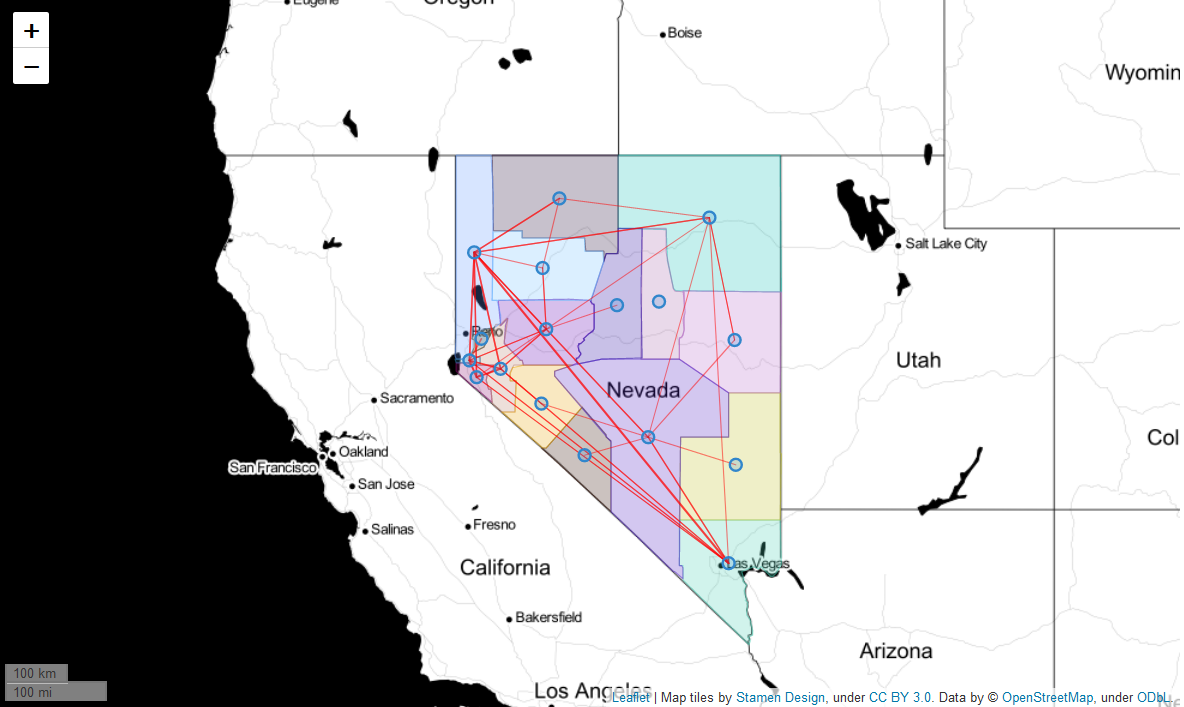

### Generating a Baseline to compare the model to

In [ ]:
# Flattening the population distribution to remove the relevance
test_fdf_tessellation['FLAT'] = [test_fdf_tessellation['POPULATION'].sum() / len(test_fdf_tessellation)] * len(test_fdf_tessellation)

#generating the flows on the flat relevance
baseline_fdf = Radiation().generate(test_fdf_tessellation, 
                                    tile_id_column='tile_ID', 
                                    tot_outflows_column='tot_outflow',
                                    relevance_column = 'FLAT')

#plotting the tessellation
tess_map = rad_result.plot_tessellation(zoom = 6)

#plotting the flows of the baseline in blue
baseline_fdf.plot_flows(map_f = tess_map, flow_color='blue',
                        flow_weight = 1, flow_exp = 0.2, min_flow = 30)

#plotting the test flows in red
test_fdf.plot_flows(map_f=tess_map, flow_color='red', 
                    flow_weight = 1, flow_exp = 0.2, min_flow = 30)

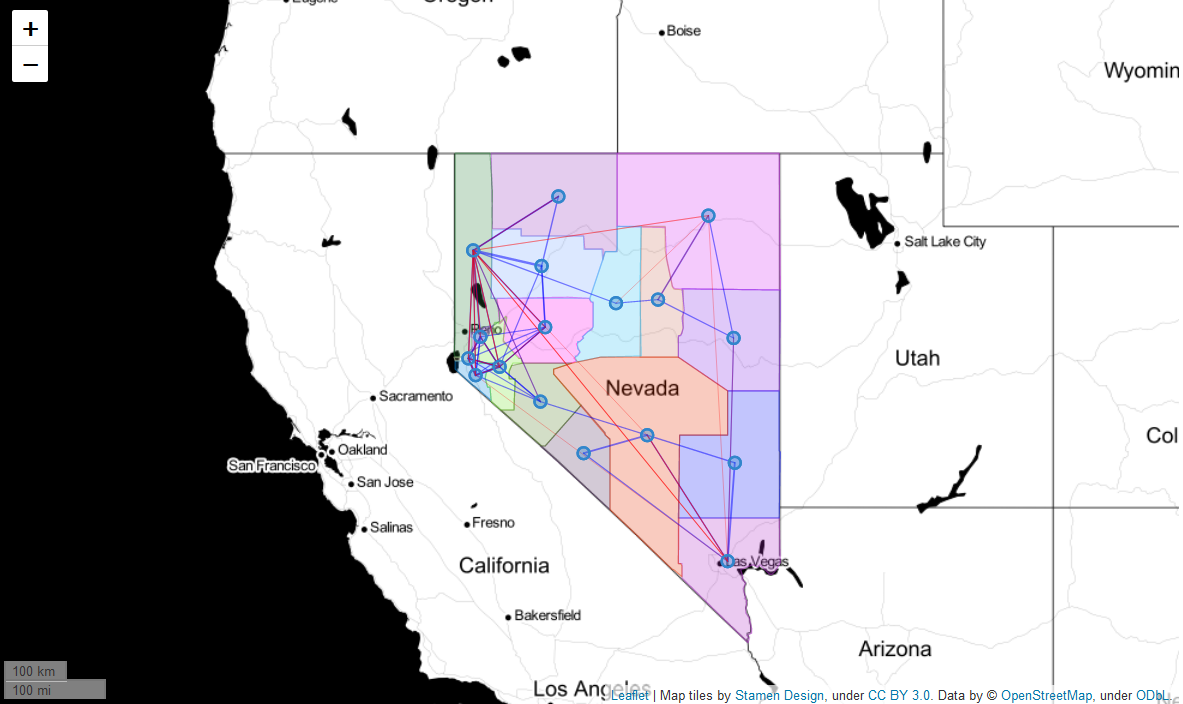

### Qualitative Evaluation

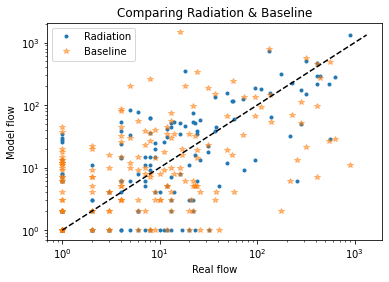

In [63]:
#comparing the test flows with those generated by the radiation model 
xy_rad = test_fdf.merge(rad_result, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
#comparing the test flows with those generated by the baseline model 
xy_baseline = test_fdf.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

#plotting them
plt.plot(xy_rad[:,0], xy_rad[:,1], '.', label='Radiation')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')

x = np.logspace(0, np.log10(np.max(xy_rad)))

plt.plot(x, x, '--k')
plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Radiation & Baseline')
plt.show()

### Quantitative Evaluation

In [64]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_rad = list()

for i, metric in enumerate(metrics):
    m = metric(xy_rad[:, 0], xy_rad[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    baseline_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_rad.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {baseline_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Radiation \t\t Baseline')
print('-'*int(1.2*len(max(report_rad, key=lambda x: len(x))) // 1))
[print(row) for row in report_rad];

Metric:                           	 Radiation 		 Baseline
---------------------------------------------------------------------------------
r_squared:                          	 0.396            	 -0.824
mse:                                	 11776.689           	 29445.32
spearman_correlation:               	 0.57            	 0.385
pearson_correlation:                	 0.726            	 0.228
common_part_of_commuters:           	 0.617            	 0.405
common_part_of_commuters_distance:  	 0.009            	 0.013


## Comparing the two models

### Qualitative Evaluation

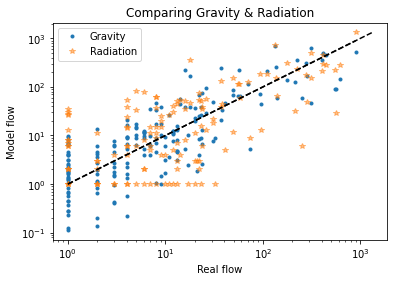

In [65]:
#comparing the test flows with those generated by the Gravity model 
plt.plot(xy_grav[:,0], xy_grav[:,1], '.', label='Gravity')
#comparing the test flows with those generated by the Radiation model 
plt.plot(xy_rad[:,0], xy_rad[:,1], '*', alpha=0.5, label='Radiation')

x = np.logspace(0, np.log10(np.max(xy_grav)))
plt.plot(x, x, '--k')

y = np.logspace(0, np.log10(np.max(xy_rad)))
plt.plot(y, y, '--k')

plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Gravity & Radiation')
plt.show()

### Quantitative Evaluation

In [66]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_both = list()

for i, metric in enumerate(metrics):
    m = metric(xy_grav[:, 0], xy_grav[:, 1])
    b = metric(xy_rad[:, 0], xy_rad[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    radiation_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_both.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {radiation_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Gravity \t\t Radiation')
print('-'*int(1.2*len(max(report_both, key=lambda x: len(x))) // 1))
[print(row) for row in report_both];

Metric:                           	 Gravity 		 Radiation
--------------------------------------------------------------------------------
r_squared:                          	 0.43            	 0.396
mse:                                	 8400.606          	 11776.689
spearman_correlation:               	 0.78            	 0.57
pearson_correlation:                	 0.691            	 0.726
common_part_of_commuters:           	 0.651            	 0.617
common_part_of_commuters_distance:  	 0.015            	 0.009


# Models with n° Education Facilities as Relevance

## Function to retrieve data from OSM

In [67]:
import time
from overpass.errors import MultipleRequestsError

def get_education_by_state(state):
    #launching the overpass api python wrapper
    api = overpass.API()
    #list of education facilities according to the OSM API (in the amenity class)
    education_facilities = ['college','kindergarten','language_school','training','music_school','school','university']

    #creating empty dataframe to append data in
    state_facilities = list()

    for facility in education_facilities:
        #the admin_level 4 is the state level, the class of the education facilities is "amenity"
        #I am getting the center of the geometries referred to the single objects
        query = f"""area[name="{state}"][admin_level=4]; node[amenity={facility}](area); out center;"""

        #to catch the http error of multiple requests
        for attempts_left in range(10):
            try:
                #getting the data as a csv (list of lists)
                get_data = api.get(query, responseformat="csv(name,::lon,::lat)")
                #break if successful
                break
            except MultipleRequestsError as e:
                if attempts_left < 9:
                    #wait 5 seconds if there are still attempts left
                    time.sleep(5)
                    continue
                else:
                    #raise the error if it's not possible to catch it with 10 attempts
                    raise e

        print(f'N° of {facility} in {state} found: {len(get_data)-1}')
        state_facilities += get_data[1:] #concatenate the data without header
        
    #get a pandas dataframe
    df_state_facilities = pd.DataFrame(state_facilities, columns = ['name', 'lng', 'lat'])

    #make a geopandas dataframe out of it
    gpd_state_facilities = gpd.GeoDataFrame(df_state_facilities,
                                            geometry=gpd.points_from_xy(df_state_facilities.lng, 
                                                                        df_state_facilities.lat))
    return gpd_state_facilities

In [68]:
#getting the data for the two states
washington_edu = get_education_by_state('Washington')
nevada_edu = get_education_by_state('Nevada')

N° of college in Washington found: 76
N° of kindergarten in Washington found: 232
N° of language_school in Washington found: 4
N° of training in Washington found: 4
N° of music_school in Washington found: 54
N° of school in Washington found: 1608
N° of university in Washington found: 18
N° of college in Nevada found: 8
N° of kindergarten in Nevada found: 22
N° of language_school in Nevada found: 0
N° of training in Nevada found: 0
N° of music_school in Nevada found: 0
N° of school in Nevada found: 716
N° of university in Nevada found: 0


In [69]:
washington_edu.head()

name           lng         lat  \
0                         Whitman College  -118.3288535  46.0706922   
1            Bellingham Technical College  -122.5109695  48.7654008   
2                Northwest Indian College  -122.6141854  48.7944135   
3              Colville Community College  -117.9016488  48.5354598   
4  Seattle Institute of Oriental Medicine  -122.3234780  47.6780451   

                      geometry  
0  POINT (-118.32885 46.07069)  
1  POINT (-122.51097 48.76540)  
2  POINT (-122.61419 48.79441)  
3  POINT (-117.90165 48.53546)  
4  POINT (-122.32348 47.67805)

In [70]:
nevada_edu.head()

name           lng  \
0     College of Southern Nevada Green Valley Center  -115.0530556   
1  Community College of Southern Nevada Summerlin...  -115.3340193   
2  Great Basin College Battle Mountain Branch Campus  -116.9300709   
3                        Arizona College - Las Vegas  -115.1713369   
4     College of Southern Nevada Green Valley Center  -115.0530556   

          lat                     geometry  
0  36.0566667  POINT (-115.05306 36.05667)  
1  36.1719865  POINT (-115.33402 36.17199)  
2  40.6425312  POINT (-116.93007 40.64253)  
3  36.1455935  POINT (-115.17134 36.14559)  
4  36.0566667  POINT (-115.05306 36.05667)

## Spatial Join of the new Relevance with the Tessellation

In [91]:
#Joining nearest tile to each education facility in order to group and count them by county

washington_edu['count'] = [0]*len(washington_edu)
washington_educounty = gpd.sjoin_nearest(washington_edu,
                                         train_fdf.tessellation).\
                                         groupby('tile_ID').count()[['count']].\
                                         reset_index()

nevada_edu['count'] = [0]*len(nevada_edu)
nevada_educounty = gpd.sjoin_nearest(nevada_edu,
                                     test_fdf.tessellation).\
                                     groupby('tile_ID').count()[['count']].\
                                     reset_index()

## Creating a Relevance dictionary { GEO_ID : n° Educational Facilities }

In [93]:
washington_relevance_dict = dict(washington_educounty.values)
nevada_relevance_dict = dict(nevada_educounty.values)

In [98]:
list(washington_relevance_dict.items())[:5]

[('0500000US53001', 16),
 ('0500000US53003', 22),
 ('0500000US53005', 18),
 ('0500000US53007', 30),
 ('0500000US53009', 32)]

In [100]:
list(nevada_relevance_dict.items())[:5]

[('0500000US32001', 26),
 ('0500000US32003', 354),
 ('0500000US32005', 22),
 ('0500000US32007', 54),
 ('0500000US32009', 2)]

## Mapping the new relevance in the tessellation

In [102]:
train_fdf.tessellation['N_EDU_FACILITIES'] = list(map(lambda x: washington_relevance_dict[x], 
                                                      train_fdf.tessellation['tile_ID']))
test_fdf.tessellation['N_EDU_FACILITIES'] = list(map(lambda x: nevada_relevance_dict[x], 
                                                     test_fdf.tessellation['tile_ID']))

In [104]:
train_fdf.tessellation.head()

tile_ID STATE COUNTY     NAME    LSAD  CENSUSAREA  \
0  0500000US53001    53    001    Adams  County    1924.978   
1  0500000US53003    53    003   Asotin  County     636.213   
2  0500000US53005    53    005   Benton  County    1700.379   
3  0500000US53007    53    007   Chelan  County    2920.525   
4  0500000US53009    53    009  Clallam  County    1738.329   

                                            geometry  POPULATION  \
0  POLYGON ((-118.04115 46.77602, -118.04117 46.7...       18802   
1  POLYGON ((-116.91750 45.99547, -116.94068 45.9...       21802   
2  POLYGON ((-119.29769 45.93574, -119.29879 45.9...      178992   
3  POLYGON ((-121.15190 47.86676, -121.15251 47.8...       73047   
4  POLYGON ((-123.78127 48.15561, -123.77947 48.1...       71731   

   N_EDU_FACILITIES  
0                16  
1                22  
2                18  
3                30  
4                32

In [105]:
test_fdf.tessellation.head()

tile_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0  0500000US32001    32    001  Churchill  County    4930.458   
1  0500000US32003    32    003      Clark  County    7891.431   
2  0500000US32005    32    005    Douglas  County     709.719   
3  0500000US32007    32    007       Elko  County   17169.834   
4  0500000US32009    32    009  Esmeralda  County    3581.876   

                                            geometry  POPULATION  \
0  POLYGON ((-118.83101 39.17113, -118.84890 39.1...       24572   
1  POLYGON ((-114.61736 35.05152, -114.62712 35.0...     1976925   
2  POLYGON ((-119.65664 38.76234, -119.67718 38.7...       47035   
3  POLYGON ((-115.73322 41.99713, -115.62591 41.9...       50023   
4  POLYGON ((-117.16600 36.97122, -117.24492 37.0...         979   

   N_EDU_FACILITIES  
0                26  
1               354  
2                22  
3                54  
4                 2

## Getting the tot outflows flows without tile-inner loops in the tessellation

In [109]:
# Computing tot outflows removing movements in to and from the same Tile
tot_outflows = train_fdf[train_fdf['origin'] != train_fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
train_fdf_tessellation = train_fdf.tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})

# Computing tot outflows removing movements in to and from the same Tile
tot_outflows = test_fdf[test_fdf['origin'] != test_fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
test_fdf_tessellation = test_fdf.tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})

## Gravity Model

### Training a Singly Constrained Gravity Model

In [110]:
#Instantiating and Training the gravity model with the n° of educational facilities as relevance
gravity_singly = Gravity(gravity_type='singly constrained')
gravity_singly.fit(train_fdf, relevance_column = 'N_EDU_FACILITIES')

### Generating flows in Nevada with the model trained on Washington's Flows

In [111]:
grav_result = gravity_singly.generate(test_fdf_tessellation, tile_id_column='tile_ID', 
                                      tot_outflows_column='tot_outflow', relevance_column= 'N_EDU_FACILITIES', out_format='flows')

100%|██████████| 17/17 [00:00<00:00, 15490.59it/s]


In [ ]:
tess_map = grav_result.plot_tessellation(zoom = 6)
grav_result.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

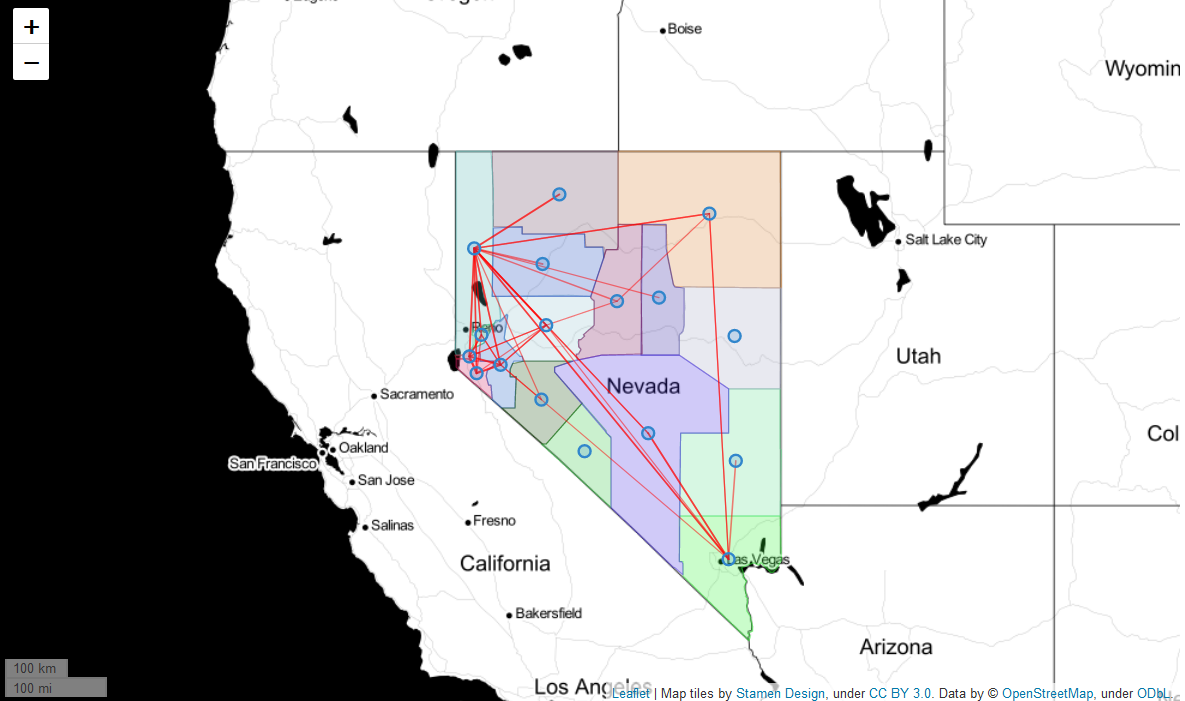

### Generating a Baseline to compare the model to

In [ ]:
#instantiating a baseline model without training
baseline = Gravity(gravity_type='singly constrained', 
                   deterrence_func_args=[0.], destination_exp=0.)
#generating the flows
baseline_fdf = baseline.generate(test_fdf_tessellation, 
                                 tile_id_column='tile_ID', 
                                 tot_outflows_column='tot_outflow',
                                 relevance_column = 'N_EDU_FACILITIES')

#plotting the tessellation
tess_map = grav_result.plot_tessellation(zoom = 6)

#plotting the baseline flows in blue
baseline_fdf.plot_flows(map_f = tess_map, flow_color='blue',
                        flow_weight = 1, flow_exp = 0.2, min_flow = 30)

#plotting the test flows in red
test_fdf.plot_flows(map_f=tess_map, flow_color='red', 
                    flow_weight = 1, flow_exp = 0.2, min_flow = 30)

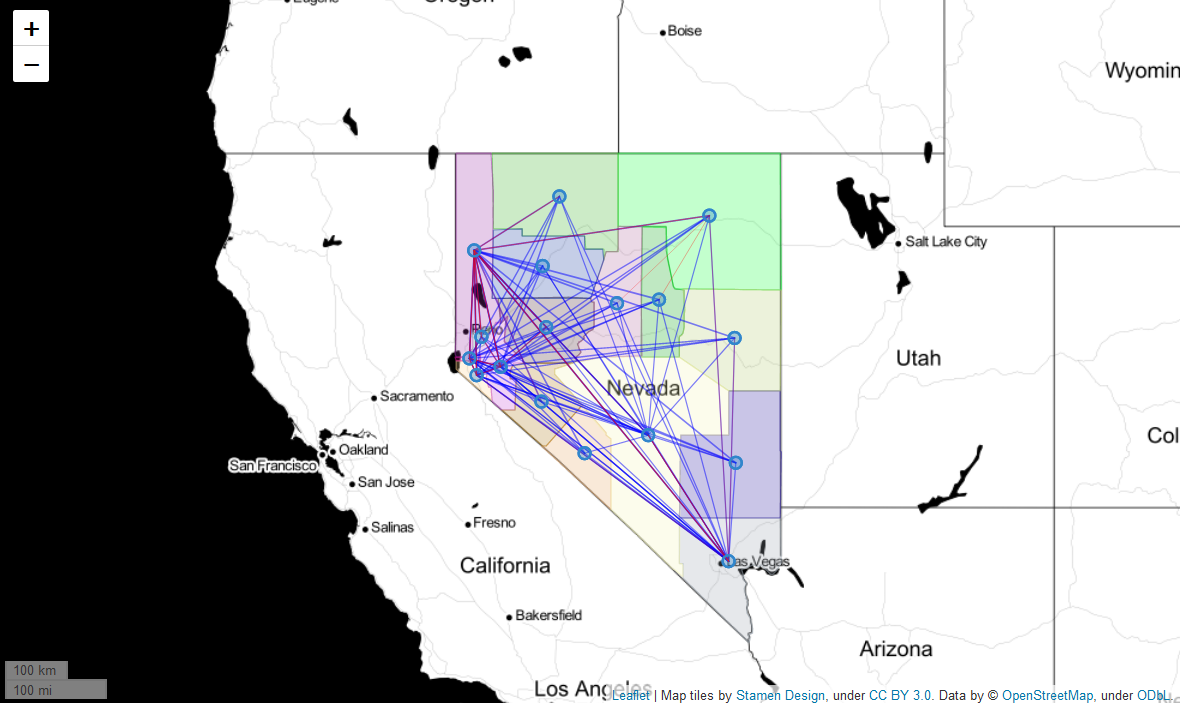

### Qualitative Evaluation

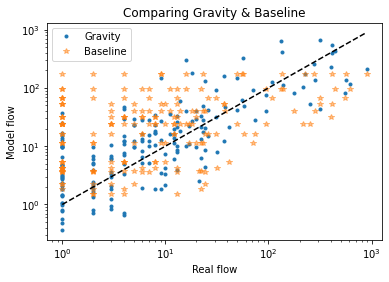

In [114]:
#comparing the test flows with those generated by the gravity model 
xy_grav = test_fdf.merge(grav_result, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
#comparing the test flows with those generated by the baseline model 
xy_baseline = test_fdf.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

#plotting them
plt.plot(xy_grav[:,0], xy_grav[:,1], '.', label='Gravity')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')

x = np.logspace(0, np.log10(np.max(xy_grav)))
plt.plot(x, x, '--k')

plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Gravity & Baseline')
plt.show()

### Quantitative Evaluation

In [115]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_grav = list()

for i, metric in enumerate(metrics):
    m = metric(xy_grav[:, 0], xy_grav[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    baseline_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_grav.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {baseline_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Gravity \t\t Baseline')
print('-'*int(1.2*len(max(report_grav, key=lambda x: len(x))) // 1))
[print(row) for row in report_grav];

Metric:                           	 Gravity 		 Baseline
---------------------------------------------------------------------------------
r_squared:                          	 0.258            	 0.152
mse:                                	 10929.052           	 12484.88
spearman_correlation:               	 0.745            	 0.353
pearson_correlation:                	 0.574            	 0.393
common_part_of_commuters:           	 0.595            	 0.391
common_part_of_commuters_distance:  	 0.015            	 0.008


## Radiation Model

In [116]:
#instantiating the radiation model and generating the flows
rad_result = Radiation().generate(test_fdf_tessellation, 
                                 relevance_column='N_EDU_FACILITIES')

100%|██████████| 17/17 [00:00<00:00, 2820.76it/s]


In [ ]:
tess_map = rad_result.plot_tessellation(zoom = 6)
rad_result.plot_flows(map_f = tess_map, flow_weight = 1, flow_exp = 0.2, min_flow = 30)

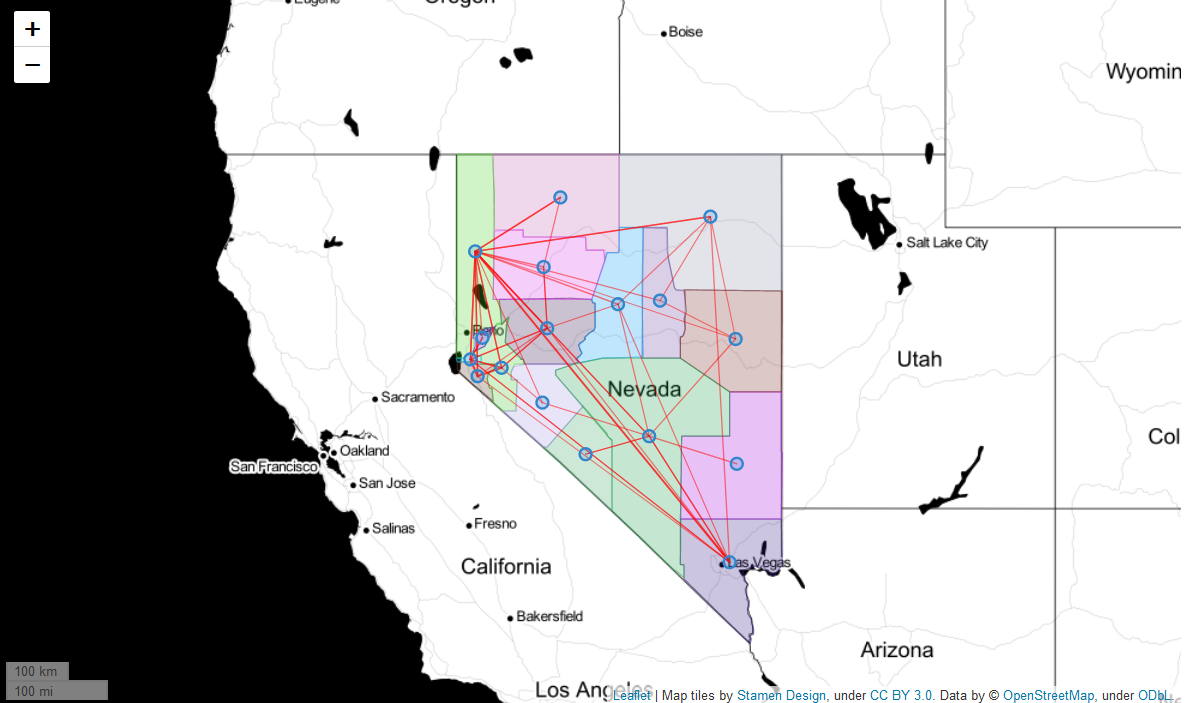

### Generating a Baseline to compare the model to

In [ ]:
# Flattening the n° of education facilities distribution to remove the relevance
test_fdf_tessellation['FLAT'] = [test_fdf_tessellation['N_EDU_FACILITIES'].sum() / len(test_fdf_tessellation)] * len(test_fdf_tessellation)

#generating the flows on the flat relevance
baseline_fdf = Radiation().generate(test_fdf_tessellation, 
                                    tile_id_column='tile_ID', 
                                    tot_outflows_column='tot_outflow',
                                    relevance_column = 'FLAT')

#plotting the tessellation
tess_map = rad_result.plot_tessellation(zoom = 6)

#plotting the flows of the baseline in blue
baseline_fdf.plot_flows(map_f = tess_map, flow_color='blue',
                        flow_weight = 1, flow_exp = 0.2, min_flow = 30)

#plotting the test flows in red
test_fdf.plot_flows(map_f=tess_map, flow_color='red', 
                    flow_weight = 1, flow_exp = 0.2, min_flow = 30)

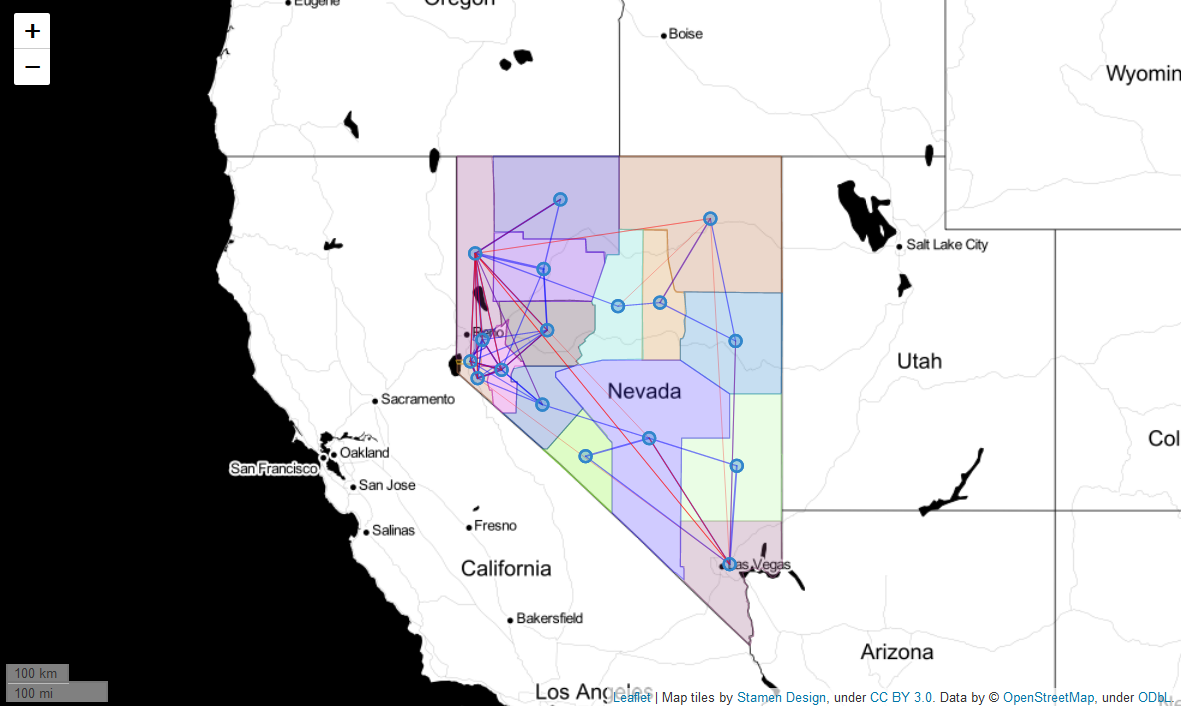

### Qualitative Evaluation

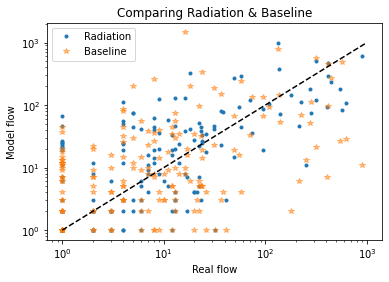

In [119]:
#comparing the test flows with those generated by the radiation model 
xy_rad = test_fdf.merge(rad_result, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
#comparing the test flows with those generated by the baseline model 
xy_baseline = test_fdf.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

#plotting them
plt.plot(xy_rad[:,0], xy_rad[:,1], '.', label='Radiation')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')
x = np.logspace(0, np.log10(np.max(xy_rad)))

plt.plot(x, x, '--k')
plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Radiation & Baseline')
plt.show()

### Quantitative Evaluation

In [120]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_rad = list()

for i, metric in enumerate(metrics):
    m = metric(xy_rad[:, 0], xy_rad[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    baseline_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_rad.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {baseline_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Radiation \t\t Baseline')
print('-'*int(1.2*len(max(report_rad, key=lambda x: len(x))) // 1))
[print(row) for row in report_rad];

Metric:                           	 Radiation 		 Baseline
----------------------------------------------------------------------------------
r_squared:                          	 0.175            	 -0.824
mse:                                	 14815.376           	 29445.136
spearman_correlation:               	 0.576            	 0.385
pearson_correlation:                	 0.552            	 0.228
common_part_of_commuters:           	 0.55            	 0.405
common_part_of_commuters_distance:  	 0.01            	 0.013


## Comparing the two models

### Qualitative Evaluation

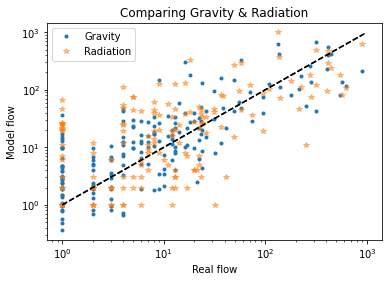

In [121]:
#comparing the test flows with those generated by the Gravity model 
plt.plot(xy_grav[:,0], xy_grav[:,1], '.', label='Gravity')
#comparing the test flows with those generated by the Radiation model 
plt.plot(xy_rad[:,0], xy_rad[:,1], '*', alpha=0.5, label='Radiation')

x = np.logspace(0, np.log10(np.max(xy_grav)))
plt.plot(x, x, '--k')

y = np.logspace(0, np.log10(np.max(xy_rad)))
plt.plot(y, y, '--k')

plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog()
plt.title('Comparing Gravity & Radiation')
plt.show()

### Quantitative Evaluation

In [122]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, 
           common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 
         'common_part_of_commuters', 'common_part_of_commuters_distance']

report_both = list()

for i, metric in enumerate(metrics):
    m = metric(xy_grav[:, 0], xy_grav[:, 1])
    b = metric(xy_rad[:, 0], xy_rad[:, 1])
    metric_name = names[i]
    space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len(metric_name))

    ### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
    gravity_value = np.round(m, 3) if type(np.round(m, 3)) == np.float64 else np.round(m, 3)[0]
    radiation_value = np.round(b, 3) if type(np.round(b, 3)) == np.float64 else np.round(b, 3)[0]

    padding_space_value = ' '*(10 if len(str(gravity_value)) < 8 else len(str(gravity_value)))
    report_both.append(f"{metric_name}: {space_to_pad_metric} \t {gravity_value} {padding_space_value} \t {radiation_value}")

### ALERT: JUST SOME TINKERING WITH BLANK SPACES TO ADJUST THE VISUALIZATION
space_to_pad_metric = ' '*(len(max(names, key=lambda x: len(x)))-len('Metric: '))
print(f'Metric: {space_to_pad_metric} \t Gravity \t\t Radiation')
print('-'*int(1.2*len(max(report_both, key=lambda x: len(x))) // 1))
[print(row) for row in report_both];

Metric:                           	 Gravity 		 Radiation
----------------------------------------------------------------------------------
r_squared:                          	 0.258            	 0.175
mse:                                	 10929.052           	 14815.376
spearman_correlation:               	 0.745            	 0.576
pearson_correlation:                	 0.574            	 0.552
common_part_of_commuters:           	 0.595            	 0.55
common_part_of_commuters_distance:  	 0.015            	 0.01
